### Prepare dataset with N1, N2, side roads and their intersections

#### Imports

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import geopy.distance

#### Load raw dataset

In [85]:
bridges = pd.read_excel('../data/raw/BMMS_overview.xlsx')    

#### Create dataframes for each N-road

In [86]:
#Keep only N-roads
bridges = bridges[(bridges['road'].str[0] == 'N')]

In [87]:
#Find all names of N-roads
N_roads = {}
for N_road in list(bridges.road.unique()):
    N_roads[N_road] = bridges[(bridges['road'] == N_road)]

In [88]:
#Example
N_roads['N514']

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
3603,N514,5.645,Box Culvert,LRP005a,.,13.25,A,110403,Bogra (Banani)-Matidali Road,5.645,8.45,1992.0,2.0,Rangpur,Bogra,Bogra,Bogra,24.864778,89.372249,interpolate
3604,N514,7.938,Arch Masonry,LRP007a,.,2.20,A,110408,Bogra (Banani)-Matidali Road,7.938,7.45,1994.0,1.0,Rangpur,Bogra,Bogra,Bogra,24.883399,89.362841,interpolate
3605,N514,8.158,Box Culvert,LRP008a,.,3.60,A,110410,Bogra (Banani)-Matidali Road,8.158,12.00,1995.0,1.0,Rangpur,Bogra,Bogra,Bogra,24.884793,89.361876,interpolate
10957,N514,2.967,Slab Culvert,LRP002a,.,1.45,B,110401,Bogra (Banani)-Matidali Road,2.967,9.50,1991.0,1.0,Rangpur,Bogra,Bogra,Sherpur (Bogra),24.841151,89.374055,interpolate


#### Define function to prepare a specific road

In [89]:
def prepare_road(road_name, bridges):
    #filter out bridges with same LRPName keeping the one with worst condition
    bridges = bridges.sort_values('condition', ascending=False).drop_duplicates('LRPName')
    selected_columns = ['road', 'LRPName', 'type', 'condition', 'name', 'lat','lon', 'length', 'chainage']
    bridges = bridges[selected_columns]
    #set type of all LRPs to bridge
    bridges['type'] = 'bridge'
    #sort bridges on chainage
    bridges = bridges.sort_values('chainage')
    #if chainage of bridges is the same: put them together with average length
    bridges = bridges.groupby('chainage').agg({'road':'first', 'LRPName':'first', 
                                                     'type':'first', 'condition':'first', 
                                                     'name':'first', 'lat':'first', 
                                                     'lon':'first', 'length':'mean'}).reset_index()
    #cut last character of LRPName
    bridges['LRPName'] = bridges['LRPName'].str[:-1]
    #if LRPName is the same: put them together with average length and worst condition
    bridges = bridges.groupby('LRPName').agg({'road':'first', 'chainage':'first', 
                                                    'type':'first', 'condition':'first', 
                                                    'name':'first', 'lat':'first', 
                                                    'lon':'first', 'length':'mean'}).reset_index()
    #sort bridges on chainage
    bridges = bridges.sort_values('chainage')
    bridge_dict = bridges.to_dict('records')
    for i,bridge in enumerate(bridge_dict):
        #add source at start of road
        if i == 0:
            bridge_dict.insert(0, {'road':road_name, 'type':'sourcesink', 
                                   'length':1, 'condition':'NaN', 
                                   'LRPName':bridge['LRPName'],'name':'SoSi_' + road_name,
                                   'chainage':0,'lat':bridge['lat'],'lon':bridge['lon']})
            bridge_dict.insert(1, {'road':road_name, 'type':'link', 
                                   'length':bridge_dict[i+1]['chainage']*1000, 
                                   'condition':'NaN', 'LRPName':bridge['LRPName']+'-road',
                                   'name':'link_' + bridge['LRPName'],'chainage':0,
                                   'lat':bridge['lat'],'lon':bridge['lon']})
        #add links in between bridges
        elif i%2 == 0 and i < len(bridge_dict)-1:
            #add link between bridges
            road_length = (bridge_dict[i+1]['chainage']-bridge['chainage'])*1000-bridge['length'] if (bridge_dict[i+1]['chainage']-bridge['chainage'])*1000-bridge['length'] > 0 else 0
            bridge_dict.insert(i+1, {'road':road_name, 'type':'link', 
                                     'length':road_length, 'condition':'NaN', 
                                     'LRPName':bridge['LRPName']+'-road','name':'link_' + bridge['LRPName'],
                                     'chainage':bridge['chainage']+bridge['length']/1000,
                                     'lat':bridge['lat'],'lon':bridge['lon']})
        #add sink at end of road
        elif i == len(bridge_dict)-1 and bridge['type']!='sourcesink': 
            bridge_dict.append({'road':road_name, 'type':'link', 
                                'length':bridge['length'],'condition':'NaN',
                                'LRPName':bridge['LRPName']+'-road','name':'link_' + bridge['LRPName'],
                                'chainage':bridge['chainage']+bridge['length']/1000,
                                'lat':bridge['lat'],'lon':bridge['lon']}) 
            bridge_dict.append({'road':road_name, 'type':'sourcesink', 
                                'length':1, 'condition':'NaN', 
                                'LRPName':'LRP235','name':'SoSi_' + road_name,
                                'chainage':bridge['chainage']+bridge['length']/1000,
                                'lat':bridge['lat'],'lon':bridge['lon']}) 

    #dict to dataframe
    bridges_cleaned = pd.DataFrame(bridge_dict)
    
    #rename type to model_type
    bridges_cleaned = bridges_cleaned.rename(columns={'type': 'model_type'})
    #Add LRPName to name if name is only .
    bridges_cleaned['name'] = np.where(bridges_cleaned['name'] == '.', bridges_cleaned['LRPName'], bridges_cleaned['name'])
    #insert column id with index
    bridges_cleaned.insert(1, 'id', bridges_cleaned.index)
    #Change column order
    bridges_cleaned = bridges_cleaned[['road', 'id', 'model_type', 'condition', 'name', 'lat', 'lon', 'length', 'chainage']]
    return bridges_cleaned

#### Prepare N-roads

In [90]:
#Empty dictionary for cleaned roads
N_roads_cleaned = {} 

In [91]:
#Loop over all N roads, clean the road, and add it to dictionary
for index, value in tqdm(N_roads.items()):
    N_roads_cleaned[index] = prepare_road(index, value)

  0%|          | 0/56 [00:00<?, ?it/s]

In [92]:
#Example of cleaned road
N_roads_cleaned['N514']

,road,id,model_type,condition,name,lat,lon,length,chainage
0,N514,0,sourcesink,NaN,SoSi_N514,24.841151,89.374055,1.00,0.00000
1,N514,1,link,NaN,link_LRP002,24.841151,89.374055,2967.00,0.00000
2,N514,2,bridge,B,LRP002,24.841151,89.374055,1.45,2.96700
3,N514,3,link,NaN,link_LRP002,24.841151,89.374055,2676.55,2.96845
4,N514,4,bridge,A,LRP005,24.864778,89.372249,13.25,5.64500
5,N514,5,link,NaN,link_LRP005,24.864778,89.372249,2279.75,5.65825
6,N514,6,bridge,A,LRP007,24.883399,89.362841,2.20,7.93800
7,N514,7,link,NaN,link_LRP007,24.883399,89.362841,217.80,7.94020
8,N514,8,bridge,A,LRP008,24.884793,89.361876,3.60,8.15800
9,N514,9,link,NaN,link_LRP008,24.884793,89.361876,3.60,8.16160


#### Remove N roads shorter than 25 km

In [93]:
#How many roads we started with
len(N_roads_cleaned)

56

In [94]:
#Remove N roads based on chainage values.
for index, value in N_roads_cleaned.copy().items():
    if value.iloc[-1]['chainage'] < 25:
        N_roads_cleaned.pop(index)

In [95]:
#How many roads we are left with
len(N_roads_cleaned)

27

#### Plot roads for Inspection

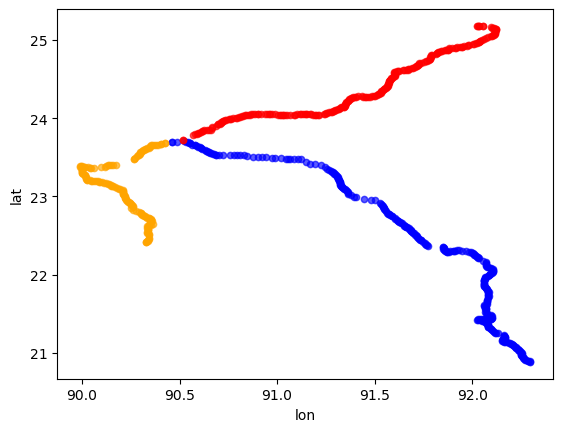

In [96]:
#Plot N1 and N2
ax = N_roads_cleaned["N1"].plot(kind="scatter", x="lon", y="lat", alpha=0.4, color='blue')
N_roads_cleaned["N2"].plot(ax=ax, kind="scatter", x="lon", y="lat", alpha=0.4, color='red')
N_roads_cleaned["N8"].plot(ax=ax, kind="scatter", x="lon", y="lat", alpha=0.4, color='orange')
plt.show()

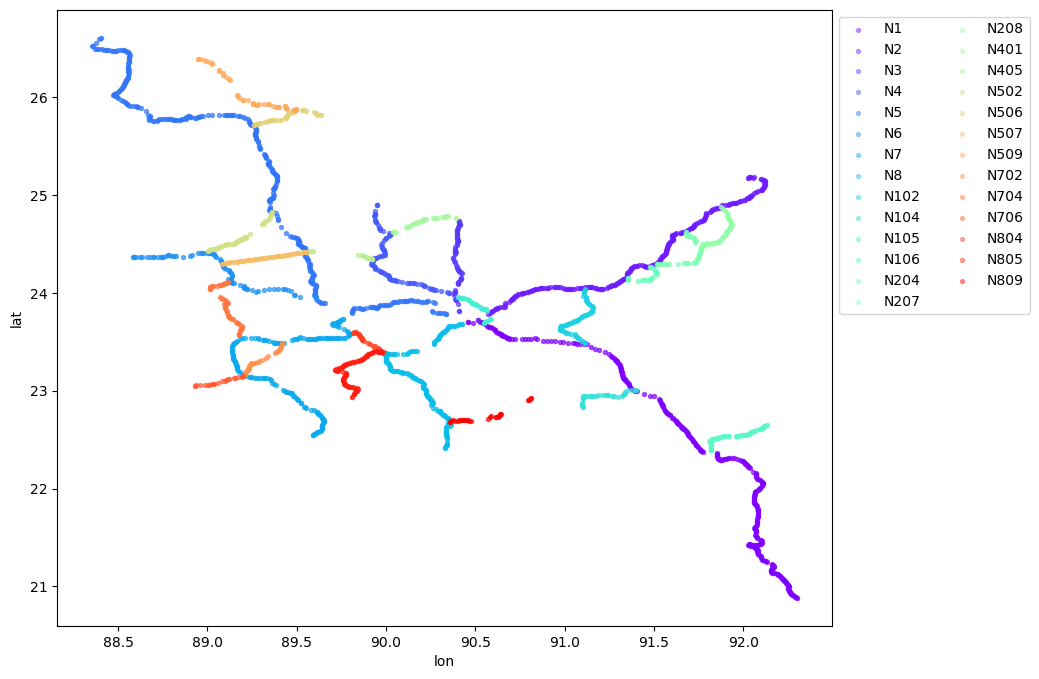

In [97]:
#Plot all N roads longer than 25 km
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(N_roads_cleaned))))
fig, ax = plt.subplots(figsize=(10, 8))
for item, value in N_roads_cleaned.items():
    c = next(color)
    value.plot(ax=ax, kind="scatter", x="lon", y="lat", alpha=0.4, s=8, label=item, c=c.reshape(1,-1))
ax.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.show()

### Identifying Intersections

#### Define function to calculate distance between points

In [98]:
def compute_distance(p1, p2):
    p1 = (p1["lat"], p1["lon"])
    p2 = (p2["lat"], p2["lon"])
    return geopy.distance.geodesic(p1, p2).km

In [99]:
p1 = N_roads_cleaned["N1"].iloc[0]
p2 = N_roads_cleaned["N1"].iloc[4]
compute_distance(p1, p2)

2.9832224668539635

#### Find potential intersections between N1 & N2 and other roads

In [100]:
def find_intersections(road, infrastructure, radius): # n1, and all non-n1 roads
    #Create new df for intersections
    intersections = pd.DataFrame(columns = ['road', 'road2', 'id', 'model_type', 'condition', 'name',
                                            'lat', 'lon', 'length', 'chainage', 'chainage2', 'distance_between_roads'])
    #Loop n1
    for index_n1, bridge_n1 in tqdm(road.iterrows()): 
        previous_dist = 1000000
    
        #Loop each road in bridge_other
        for item, value in N_roads_cleaned.items(): 

            #Loop each LRP per road
            for index_other, bridge_other in value.iterrows(): 
                distance = compute_distance(bridge_n1, bridge_other)

                #Within boundaries of n1's LRP
                if distance < radius:
                    if (bridge_n1.model_type != "Bridge") and (bridge_other.model_type != "Bridge"):
                        new_index = len(intersections.index)
                        row = {'road':bridge_n1["road"],
                            'road2':(bridge_other["road"]),
                            'id': None,
                            'model_type':'intersection',
                            'condition': 'NaN',
                            'name':"IS_" + str(bridge_n1["road"]) + str(bridge_other["road"]),
                            'lat':((bridge_n1['lat'] + bridge_other['lat']) / 2),
                            'lon':((bridge_n1['lon'] + bridge_other['lon']) / 2),
                            'length': 20,
                            'chainage':bridge_n1['chainage']+0.001,
                            'chainage2':bridge_other['chainage']+0.001,
                            'distance_between_roads':distance}
                        intersections.loc[new_index] = row
                previous_dist = distance

    intersections = intersections.sort_values(['road', 'name', 'chainage'])
    return intersections

In [101]:
#Save road N1 and remove from dictionary
road_n1 = N_roads_cleaned.pop("N1")

#Find all possible intersections for N1
intersections_n1 = find_intersections(road_n1, N_roads_cleaned, 13)

0it [00:00, ?it/s]

In [102]:
#Save road N2 and remove from dictionary
road_n2 = N_roads_cleaned.pop("N2")

#Find all possible intersections for N2
intersections_n2 = find_intersections(road_n2, N_roads_cleaned, 13)

0it [00:00, ?it/s]

#### Find final intersections by removing duplicates

In [103]:
def remove_intersection_duplicates(intersections_df, threshold):
    intersections = intersections_df.copy()
    prv_road = "ABCROAD"
    prv_index = 69696969
    prv_length = len(intersections)+1

    #Algorithm compares two neighbouring intersections each iteration (like a bubble sort)
    #Will terminate run when no other points are removed
    while (len(intersections) != prv_length):
        prv_length = len(intersections)

        #Loop through all potential intersections
        for index, inters in tqdm(intersections.iterrows()):
            cur_road = inters["road2"]
            
            #If within same road
            if (cur_road == prv_road):
                
                #If two points are near (same intersection)
                if compute_distance(inters, prv_inters) < threshold:

                    #If current point is worse than previous point
                    if (inters['distance_between_roads'] >= prv_inters['distance_between_roads']):
                        #drop current point
                        intersections.drop(index, inplace=True, errors="ignore")
                        
                    #Check if previous index still exists to delete    
                    elif(prv_index in intersections.index): 
                        #drop previous point
                        intersections.drop(prv_index, inplace=True, errors="ignore")

                    #Both points are still legitimate
                    else:
                        pass

                #Two points are far (different intersection)
                else: 
                    pass
            
            prv_road = cur_road
            prv_inters = inters
            prv_index = index

    return intersections

In [104]:
#Clean potential intersections in N1
intersections_n1_ = remove_intersection_duplicates(intersections_n1,13)

#Visualize N1
intersections_n1_.head(10)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,road,road2,id,model_type,condition,name,lat,lon,length,chainage,chainage2,distance_between_roads
1164,N1,N102,None,intersection,NaN,IS_N1N102,23.482349,91.110225,20,80.950,0.001,1.142174
1524,N1,N104,None,intersection,NaN,IS_N1N104,23.011122,91.376076,20,144.940,2.631,0.482733
380,N1,N105,None,intersection,NaN,IS_N1N105,23.689510,90.547638,20,12.240,0.001,0.307266
2488,N1,N106,None,intersection,NaN,IS_N1N106,22.378690,91.836153,20,242.017,0.001,5.322294
200,N1,N2,None,intersection,NaN,IS_N1N2,23.711562,90.519493,20,8.977,0.001,1.628116
4,N1,N8,None,intersection,NaN,IS_N1N8,23.691325,90.441086,20,0.001,0.001,3.980467


In [105]:
#Clean potential intersections in N2
intersections_n2_ = remove_intersection_duplicates(intersections_n2, 13)

#Visualize N2
intersections_n2_.head(10)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,road,road2,id,model_type,condition,name,lat,lon,length,chainage,chainage2,distance_between_roads
980,N2,N102,None,intersection,NaN,IS_N2N102,24.045794,91.107564,20,84.420,81.780,1.493541
238,N2,N105,None,intersection,NaN,IS_N2N105,23.810564,90.576576,20,14.334,16.586,2.505532
1824,N2,N204,None,intersection,NaN,IS_N2N204,24.151430,91.350086,20,117.087,0.001,0.731630
2778,N2,N204,None,intersection,NaN,IS_N2N204,24.267422,91.477096,20,141.383,34.301,0.188402
3055,N2,N207,None,intersection,NaN,IS_N2N207,24.296680,91.512094,20,146.095,0.001,0.372210
4504,N2,N207,None,intersection,NaN,IS_N2N207,24.623715,91.675485,20,190.385,67.561,0.580146
5354,N2,N208,None,intersection,NaN,IS_N2N208,24.877652,91.874497,20,227.582,57.090,0.194157
0,N2,N8,None,intersection,NaN,IS_N2N8,23.700988,90.469541,20,0.001,0.001,10.160082


### Plot intersections

In [106]:
#Get all roads which need to be plotted next to the N1
plot_roads = list(intersections_n1_.name.unique()) + list(intersections_n2_.name.unique())

#Remove first 5 char in list
plot_roads = [sub[5:] for sub in plot_roads]

#Drop duplicates
plot_roads = list(dict.fromkeys(plot_roads))

#Remove N2
plot_roads.remove('N2')
print(plot_roads)

['N102', 'N104', 'N105', 'N106', 'N8', 'N204', 'N207', 'N208']


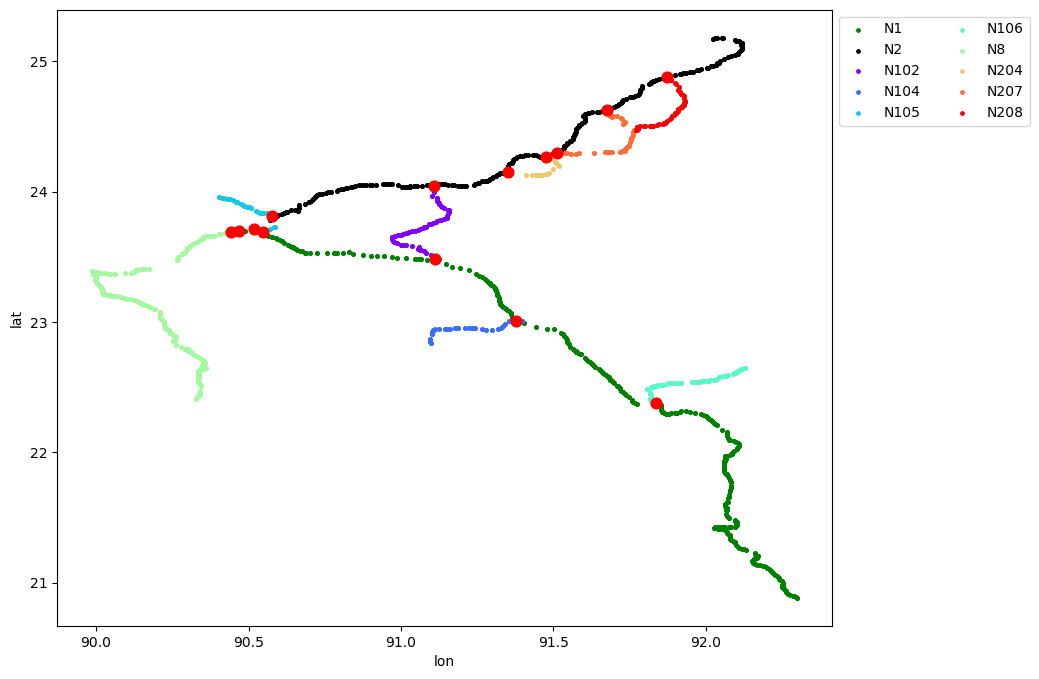

In [107]:
#Plot all N roads longer than 25 km connected to N1 or N2
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(plot_roads))))
fig, ax = plt.subplots(figsize=(10, 8))
road_n1.plot(ax=ax, kind="scatter", x="lon", y="lat", s=6, label='N1', color='green')
road_n2.plot(ax=ax, kind="scatter", x="lon", y="lat", s=6, label='N2', color='black')
for road in plot_roads:
    c = next(color)
    N_roads_cleaned[road].plot(ax=ax, kind="scatter", x="lon", y="lat", s=6, label=road, c=c.reshape(1,-1))
intersections_n1_.plot(ax=ax, kind="scatter", x="lon", y="lat",s=60, color='red')
intersections_n2_.plot(ax=ax, kind="scatter", x="lon", y="lat",s=60, color='red')
ax.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.show()

### Prepararing to Export

#### Create final dataframe for model

In [108]:
#Add all dataframes of roads to a list
frames = [intersections_n1_, road_n1, intersections_n2_, road_n2]
for road in plot_roads:
    frames.append(N_roads_cleaned[road])
    
#Concatenate all those dataframes
final = pd.concat(frames)

In [109]:
#Sort on road and chainage
final = final.sort_values(['road', 'chainage'])

#Drop distance_between_roads
final = final.drop('distance_between_roads', axis=1)

#Reset the index
final.index = pd.RangeIndex(start=1000000, stop=1000000+len(final), step=1)

#Set column id as index
final['id'] = final.index

In [110]:
#Visualize complete dataframe
final.head()

,road,road2,id,model_type,condition,name,lat,lon,length,chainage,chainage2
1000000,N1,NaN,1000000,sourcesink,NaN,SoSi_N1,23.698739,90.458861,1.0,0.0000,NaN
1000001,N1,NaN,1000001,link,NaN,link_LRP001,23.698739,90.458861,1800.0,0.0000,NaN
1000002,N1,N8,1000002,intersection,NaN,IS_N1N8,23.691325,90.441086,20.0,0.0010,0.001
1000003,N1,NaN,1000003,bridge,A,LRP001,23.698739,90.458861,11.3,1.8000,NaN
1000004,N1,NaN,1000004,link,NaN,link_LRP001,23.698739,90.458861,3113.7,1.8113,NaN


In [111]:
#Check Intersections ouput

#Get intersections
intersections_nrest = final.copy()
intersections_nrest = intersections_nrest[intersections_nrest['model_type'] == 'intersection']

#Drop distance_between_roads and road in intersection dataframes of other roads
intersections_nrest = intersections_nrest.drop(['road', 'chainage'], axis=1)
intersections_nrest.rename(columns={'road2':'road', 'chainage2':'chainage'}, inplace=True)

#Visualize all intersections
intersections_nrest.head(20)

,road,id,model_type,condition,name,lat,lon,length,chainage
1000002,N8,1000002,intersection,NaN,IS_N1N8,23.691325,90.441086,20.0,0.001
1000008,N2,1000008,intersection,NaN,IS_N1N2,23.711562,90.519493,20.0,0.001
1000015,N105,1000015,intersection,NaN,IS_N1N105,23.689510,90.547638,20.0,0.001
1000100,N102,1000100,intersection,NaN,IS_N1N102,23.482349,91.110225,20.0,0.001
1000185,N104,1000185,intersection,NaN,IS_N1N104,23.011122,91.376076,20.0,2.631
1000310,N106,1000310,intersection,NaN,IS_N1N106,22.378690,91.836153,20.0,0.001
1001045,N8,1001045,intersection,NaN,IS_N2N8,23.700988,90.469541,20.0,0.001
1001053,N105,1001053,intersection,NaN,IS_N2N105,23.810564,90.576576,20.0,16.586
1001172,N102,1001172,intersection,NaN,IS_N2N102,24.045794,91.107564,20.0,81.780
1001237,N204,1001237,intersection,NaN,IS_N2N204,24.151430,91.350086,20.0,0.001


In [112]:
#Drop some columns in final
final = final.drop(['road2', 'chainage2'], axis=1)

#Finally merge intersections_nrest with final
final = pd.concat([final, intersections_nrest])

#Sort values
final = final.sort_values(['road', 'chainage'])

#Drop chainage column
final = final.drop('chainage', axis=1)

In [113]:
#Checking a single intersection and ensuring the right format (duplicated)
final.loc[1000002]

,road,id,model_type,condition,name,lat,lon,length
1000002,N1,1000002,intersection,NaN,IS_N1N8,23.691325,90.441086,20.0
1000002,N8,1000002,intersection,NaN,IS_N1N8,23.691325,90.441086,20.0


#### Save final df to csv

In [114]:
#Save to csv
final.to_csv('../data/infrastructure.csv', index=False)